# Linear Discriminant Analysis

LDA attempts to identify a dimension in which the separation between classes is maximized. It can be implemented using linear algebra or the ISLR formulation. In the accompanying chapter we illustrated using iris to show that LDA can handle multi-class problems. Here, we will customize it for heart dataset, a binary classification problem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

path = "heart.csv"
heart = pd.read_csv(path)

In [2]:
nvpairsdf3 = []
for col in heart.columns:
    nvpairsdf3.append({"cname": col, "uvalfreq":len(heart[col].unique())})
nvpairsdf3 = pd.DataFrame(nvpairsdf3)
nvpairsdf3

,cname,uvalfreq
0,age,41
1,sex,2
2,cp,4
3,trestbps,49
4,chol,152
5,fbs,2
6,restecg,3
7,thalach,91
8,exang,2
9,oldpeak,40


In [3]:
def categorical_features(dset, ncol=7):
    df4 = []
    for col in dset.columns:
        df4.append({"cname": col, "uvalfreq":len(dset[col].unique())})
    df4 = pd.DataFrame(df4)
    cols = df4[df4.uvalfreq <= ncol]["cname"].values.tolist()
    return(dset[cols])
X = categorical_features(heart)

In [4]:
heart["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

In [5]:
X.shape

(303, 9)

In [6]:
heart0 = X[X.target == 0]
heart1 = X[X.target == 1]
print(heart0.columns)

Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal',
       'target'],
      dtype='object')


## Let us compute class means for each feature

data.frames and vector manipulation

In [7]:
# The R code no longer uses the target
heart0 = heart0.drop("target", axis=1)
heart1 = heart1.drop("target", axis=1)

heart0mean = heart0.mean(axis=0)
heart1mean = heart1.mean(axis=0)

Let us compute the mean for the entire dataset

In [8]:
allclassmean = X.drop("target", axis=1).mean(axis=0)

And the covariances

In [9]:
S1 = heart0.cov()
S2 = heart1.cov()

Class frequencies

In [10]:
N1 = len(heart0.index)
N2 = len(heart1.index)

Let us compute pooled covariance

In [11]:
SWpooled = ((N1 - 1) * S1 + (N2 - 1) * S2) / (N1 + N2 - 2)

For LDA we need scatter between (SB) for each class.

In [12]:
SB1 = N1 * (heart0mean - allclassmean) * (heart0mean - allclassmean)
SB2 = N2 * (heart1mean - allclassmean) * (heart1mean - allclassmean)
SB = SB1 + SB2

Let us predict using linear algebra

In [13]:
invSWpooled = pd.DataFrame(np.linalg.pinv(SWpooled.values), SWpooled.columns, SWpooled.index)
invSWSBpooled = invSWpooled * SB
invSWSBpooled = invSWSBpooled.transpose()
SWSBpooledeigendecomp_values, SWSBpooledeigendecomp_vectors = np.linalg.eig(invSWSBpooled)
lambdas = pd.DataFrame(SWSBpooledeigendecomp_vectors, columns=invSWSBpooled.columns, index=invSWSBpooled.index)[invSWSBpooled.columns[SWSBpooledeigendecomp_values == max(SWSBpooledeigendecomp_values)]].values
heart_projections_pooled = X.drop("target", axis=1).dot(lambdas)

Convert probabilities into class projections...

In [14]:
rounded_heart_projections_pooled = round(heart_projections_pooled)
heart_lda_pooled = X.copy()
heart_lda_pooled["classp"] = heart_projections_pooled
heart_lda_pooled["spectral"] = rounded_heart_projections_pooled
heart_lda_pooled["predicted"] = heart_lda_pooled["spectral"].apply(lambda x: 1 if x < -1 else 0)
heart_lda_confmat_pooled = pd.DataFrame(confusion_matrix(heart_lda_pooled["target"], heart_lda_pooled["predicted"]))
heart_lda_confmat_pooled

,0,1
0,112,26
1,78,87


Not exactly impressive...
Let us calculate the metrics 

In [15]:
print("Accuracy is:: " + str(sum(np.diag(heart_lda_confmat_pooled)) / len(heart_lda_pooled.index)))

Accuracy is:: 0.6567656765676567


In [16]:
print("Error is:: " + str(1-sum(np.diag(heart_lda_confmat_pooled)) / len(heart_lda_pooled.index)))

Error is:: 0.3432343234323433


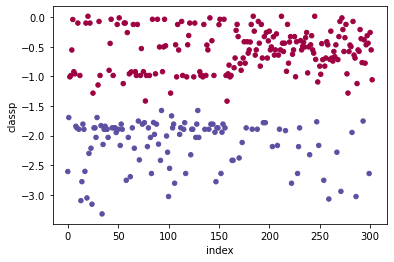

In [17]:
heart_lda_pooled.reset_index().plot.scatter(x="index", y="classp", c="predicted", colormap="Spectral", colorbar=False);

Let us now reimplement ISLR chapter 4 - implemented by Professor Dalal (Columbia.edu)
for the heart dataset.

In [18]:
default_pos = X[X.target == 0]
default_neg = X[X.target == 1]
default_pos.shape

(138, 9)

In [19]:
mu_pos = default_pos.drop("target", axis=1).mean(axis=0)
mu_neg = default_neg.drop("target", axis=1).mean(axis=0)
sigma_pos = default_pos.drop("target", axis=1).cov()
sigma_neg = default_neg.drop("target", axis=1).cov()
n_pos = len(default_pos.index)
n_neg = len(default_neg.index)
sigma_all = ((n_pos - 1) * sigma_pos + (n_neg - 1) * sigma_neg) / (n_pos + n_neg - 2) #pooled Cov matrix-
mu = pd.concat([mu_pos, mu_neg], axis=1).rename(columns={0:"mu_pos",1:"mu_neg"})
pi_vec = pd.Series([n_pos / len(X.index), n_neg / len(X.index)])
def my_lda(pi_vec, mu, Sigma, x):
    x_dims = x.shape
    n = x_dims[0]
    Sigma_inv = pd.DataFrame(np.linalg.pinv(Sigma.values), Sigma.columns, Sigma.index) #Find inverse of Sigma
    out_prod = np.zeros(n) #all items initiated to be negative
    # equation 4.19 from ISLR Sixth Printing Page 157
    discrim_pos = x.apply(lambda y : y.dot(Sigma_inv).dot(mu["mu_pos"]) - 0.5 * mu["mu_pos"].transpose().dot(Sigma_inv).dot(mu["mu_pos"]) + np.log(pi_vec[0]), axis = 1) # target == 0
    discrim_neg = x.apply(lambda y : y.dot(Sigma_inv).dot(mu["mu_neg"]) - 0.5 * mu["mu_neg"].transpose().dot(Sigma_inv).dot(mu["mu_neg"]) + np.log(pi_vec[1]), axis = 1) # target == 1 
    out_prod[discrim_neg >= discrim_pos] = 1
    out_prod = pd.Series(out_prod)
    out_prod_df = pd.concat([discrim_pos, discrim_neg, out_prod], axis=1).rename(columns={0:"posp",1:"negp", 2:"prod"})
    return(out_prod_df)


Let us run LDA on heart dataset using Sid's implementation.

In [20]:
heart_default_all = my_lda(pi_vec, mu, sigma_all, X.drop("target", axis=1))
hda = heart_default_all.copy()
hda["posprob"] = hda["posp"] / (hda["posp"] + hda["negp"])
hda["negprob"] = hda["negp"] / (hda["posp"] + hda["negp"])
#produce confusion matrices
cfmx = pd.DataFrame(confusion_matrix(X["target"], heart_default_all["prod"]))
cfmx

,0,1
0,101,37
1,22,143


Now let us run LDA using standard implementation in sklearn

In [21]:
lda_model = LinearDiscriminantAnalysis().fit(X.drop("target", axis=1), X["target"])
lda_pred = lda_model.predict(X.drop("target", axis=1))
cfmx_sklearn =  pd.DataFrame(confusion_matrix(X["target"], lda_pred))
cfmx_sklearn

,0,1
0,101,37
1,22,143


In [22]:
cr = classification_report(X["target"], heart_default_all["prod"], output_dict = True)
sid = {"Sensitivity": cr["0"]["precision"], "Specificity": cr["1"]["precision"], "Pos Pred Value":cr["0"]["recall"], "Neg Pred Value":cr["1"]["recall"], "Recall":cr["0"]["precision"], "F1":cr["0"]["f1-score"]}
cr = classification_report(X["target"], lda_pred, output_dict = True)
sklearn = {"Sensitivity": cr["0"]["precision"], "Specificity": cr["1"]["precision"], "Pos Pred Value":cr["0"]["recall"], "Neg Pred Value":cr["1"]["recall"], "Recall":cr["0"]["precision"], "F1":cr["0"]["f1-score"]}
dfcomp = pd.DataFrame([sid, sklearn], index=["sid", "sklearn"])
dfcomp

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Recall,F1
sid,0.821138,0.794444,0.731884,0.866667,0.821138,0.773946
sklearn,0.821138,0.794444,0.731884,0.866667,0.821138,0.773946


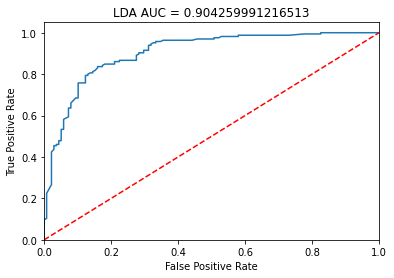

In [23]:
lda_posterior = pd.DataFrame(lda_model.predict_proba(X.drop("target", axis=1)))[1]
fpr, tpr, thresholds = roc_curve(X["target"], lda_posterior)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("LDA AUC = " + str(roc_auc_score(X["target"], lda_posterior)))
plt.show()